In [ ]:
#PREPROCESSING SCRIPT
#THIS TAKES IN THE SPLICED AND UNSPLICED MATRICES, MAKES A SUMMED COUNT MATRIX WITH EMPTYDROPS CALLED CELLS, MAKE SEURAT
#OBJECTS AND ADD MT AND CP PERCENTAGE, THEN SAVE IN SEURAT1. 

In [3]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
if (!requireNamespace("here", quietly = TRUE))
    install.packages("here")
if (!requireNamespace("ggplot2", quietly = TRUE))
    install.packages("ggplot2")
if (!requireNamespace("ggpointdensity", quietly = TRUE))
    install.packages("ggpointdensity")
if (!requireNamespace("DropletUtils", quietly = TRUE)) 
    BiocManager::install("DropletUtils")
if (!requireNamespace("BUSpaRse", quietly = TRUE)) 
    BiocManager::install("BUSpaRse")
if (!requireNamespace("scico", quietly = TRUE))
    install.packages("scico")
if (!requireNamespace("reticulate", quietly = TRUE))
    install.packages("reticulate")
if (!requireNamespace("future", quietly = TRUE))
    install.packages("future")
if (!requireNamespace("DoubletFinder", quietly = TRUE))
    remotes::install_github('chris-mcginnis-ucsf/DoubletFinder')
if (!requireNamespace("tidyverse", quietly = TRUE))
    install.packages("tidyverse")
#devtools::install_github(repo = 'satijalab/seurat', ref = 'develop')
# if (!requireNamespace("COPILOT", quietly = TRUE))
#     devtools::install_github('Hsu-Che-Wei/COPILOT')


In [ ]:
library(BUSpaRse)
library(here)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scico)
library(scales)
library(DropletUtils)
library(reticulate)
library(repr)
library(DoubletFinder)
library(future)
options(future.globals.maxSize = 100000 * 1024^2)

proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 4,]$genes)

# Slightly modified from BUSpaRse, just to avoid installing a few dependencies not used here
read_count_output <- function(dir, name) {
  dir <- normalizePath(dir, mustWork = TRUE)
  m <- readMM(paste0(dir, "/", name, ".mtx"))
  m <- Matrix::t(m)
  m <- as(m, "dgCMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  genes <- readLines(file(paste0(dir, "/", name, ge)))
  barcodes <- readLines(file(paste0(dir, "/", name, ".barcodes.txt")))
  colnames(m) <- barcodes
  rownames(m) <- genes
  return(m)
}


In [2]:
#BE SURE TO RUN read_count_output FUNCTION AT END OF THIS NOTEBOOK FIRST. THIS IS NECESSARY TO READ DATA.
#setwd
setwd(here())

#all spliced data
wt_spliced = read_count_output("../data/sc_69", "spliced")

mut_spliced = read_count_output("../data/sc_70", "spliced")


#all unspliced data
wt_unspliced = read_count_output("../data/sc_69", "unspliced")

mut_unspliced = read_count_output("../data/sc_70", "unspliced")

In [4]:
#I think empty drops here on the spliced matrices. Better to do it here than after next step which is tantamount to weak filtering
wt_empty_drops = emptyDrops(wt_spliced[grepl(pattern = "AT[1-5]", unlist(wt_spliced@Dimnames[1])),, drop=FALSE], ignore = 25, lower = 125)
mut_empty_drops = emptyDrops(mut_spliced[grepl(pattern = "AT[1-5]", unlist(mut_spliced@Dimnames[1])),, drop=FALSE], ignore = 25, lower = 125)

In [10]:
sum(wt_empty_drops$FDR<.001, na.rm = TRUE)
sum(mut_empty_drops$FDR<.001, na.rm = TRUE)

ERROR: Error in eval(expr, envir, enclos): object 'wt_empty_drops' not found


In [6]:
#Make combined spliced/unspliced. Assume real cells will be present in both lists, so take barcodes in intersection, and intersect with the emptyDrops called cells
#WT
shared = intersect(intersect(colnames(wt_spliced), colnames(wt_unspliced)), rownames(wt_empty_drops[!is.na(wt_empty_drops$FDR) & wt_empty_drops$FDR < .001,]))
wt_combined = wt_spliced[,shared] + wt_unspliced[,shared]

#mut
shared = intersect(intersect(colnames(mut_spliced), colnames(mut_unspliced)), rownames(mut_empty_drops[!is.na(mut_empty_drops$FDR) & mut_empty_drops$FDR < .001,]))
mut_combined =mut_spliced[,shared] + mut_unspliced[,shared]

#MAKE COMBINED SPLICED/UNSPLICED COUNT MATRICES FOR ALL SAMPLES. THEN REMOVE EMPTYDROPS FOR CELLS. THEN REMOVE DOUBLETS. THEN ROCK N ROLL

In [25]:
wt_seu <- CreateSeuratObject(wt_combined, min.cells = 3)
wt_seu

mut_seu <- CreateSeuratObject(mut_combined, min.cells = 3)
mut_seu

An object of class Seurat 
19531 features across 1619 samples within 1 assay 
Active assay: RNA (19531 features, 0 variable features)

An object of class Seurat 
18995 features across 1478 samples within 1 assay 
Active assay: RNA (18995 features, 0 variable features)

In [26]:
wt_seu=PercentageFeatureSet(wt_seu, pattern = "ATM", col.name = "percent.mito", assay = "RNA")
mut_seu=PercentageFeatureSet(mut_seu, pattern = "ATM", col.name = "percent.mito", assay = "RNA")

wt_seu=PercentageFeatureSet(wt_seu, pattern = "ATC", col.name = "percent.cp", assay = "RNA")
mut_seu=PercentageFeatureSet(mut_seu, pattern = "ATC", col.name = "percent.cp", assay = "RNA")

In [9]:
#Save the protoplast genes-, doublet-, high mito- seurat objects
saveRDS(wt_seu, file = "../data/seurat1/sc_69_seu_1_ED_no_min_features.rds")
saveRDS(mut_seu, file = "../data/seurat1/sc_70_seu_1_ED_no_min_features.rds")

In [2]:
wt_seu = readRDS("../data/seurat1/sc_69_seu_1_ED_no_min_features.rds")
mut_seu = readRDS("../data/seurat1/sc_70_seu_1_ED_no_min_features.rds")

In [ ]:
wt_seu = SCTransform(wt_seu, verbose = FALSE)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


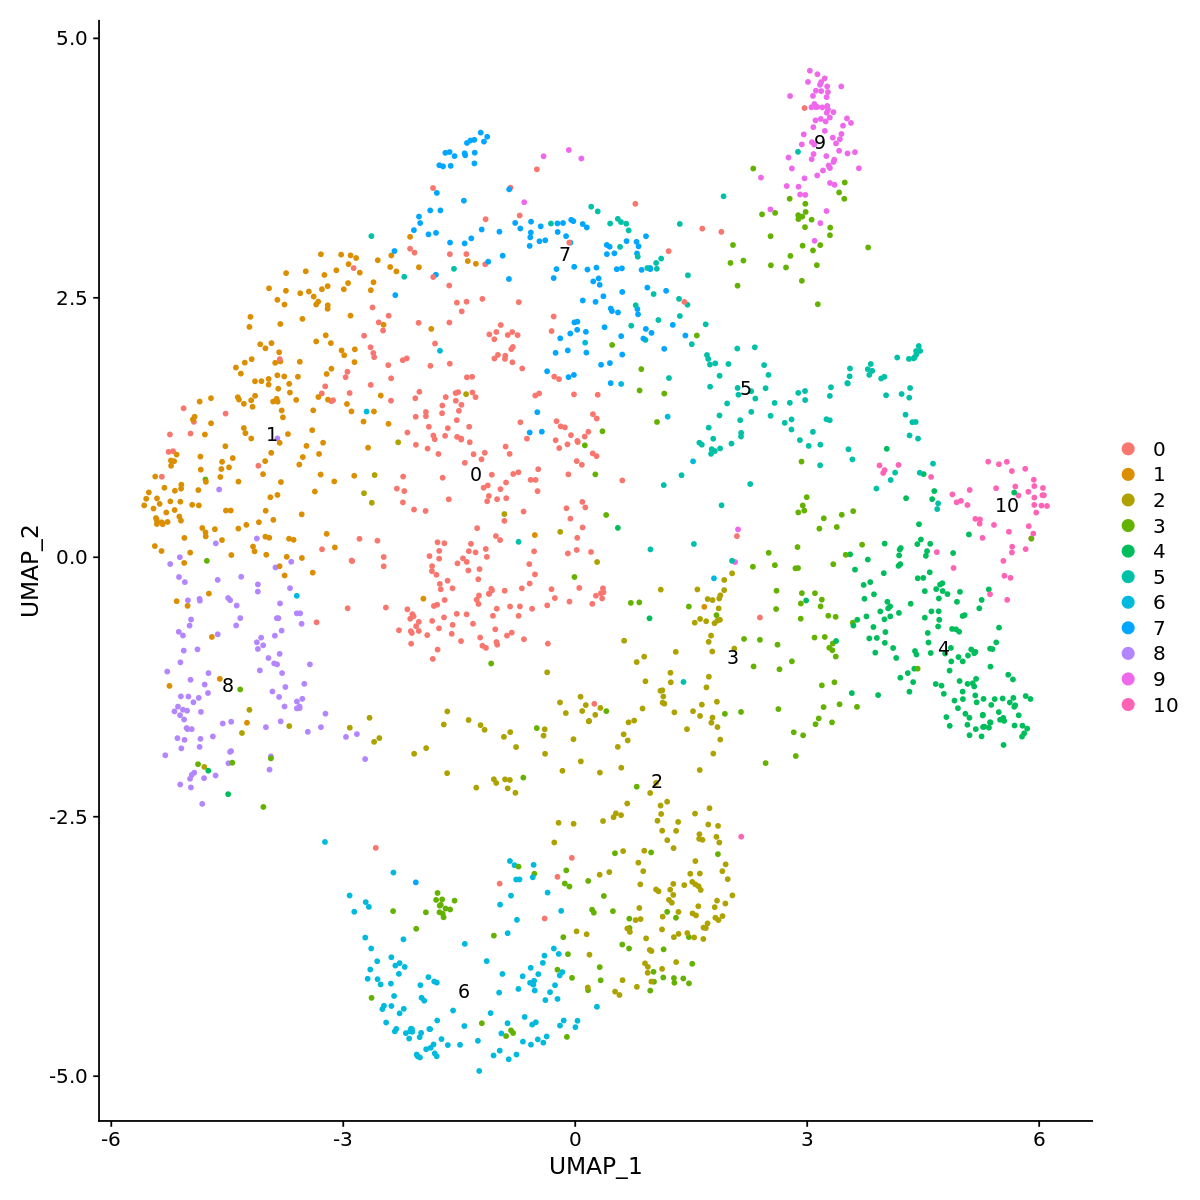

In [15]:
wt_seu <- RunPCA(wt_seu, verbose = FALSE)
wt_seu <- RunUMAP(wt_seu, dims = 1:30, verbose = FALSE)

wt_seu <- FindNeighbors(wt_seu, dims = 1:15, verbose = FALSE)
wt_seu <- FindClusters(wt_seu, verbose = FALSE)
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(wt_seu, label = TRUE) 

In [ ]:
mut_seu = SCTransform(mut_seu, verbose = FALSE)

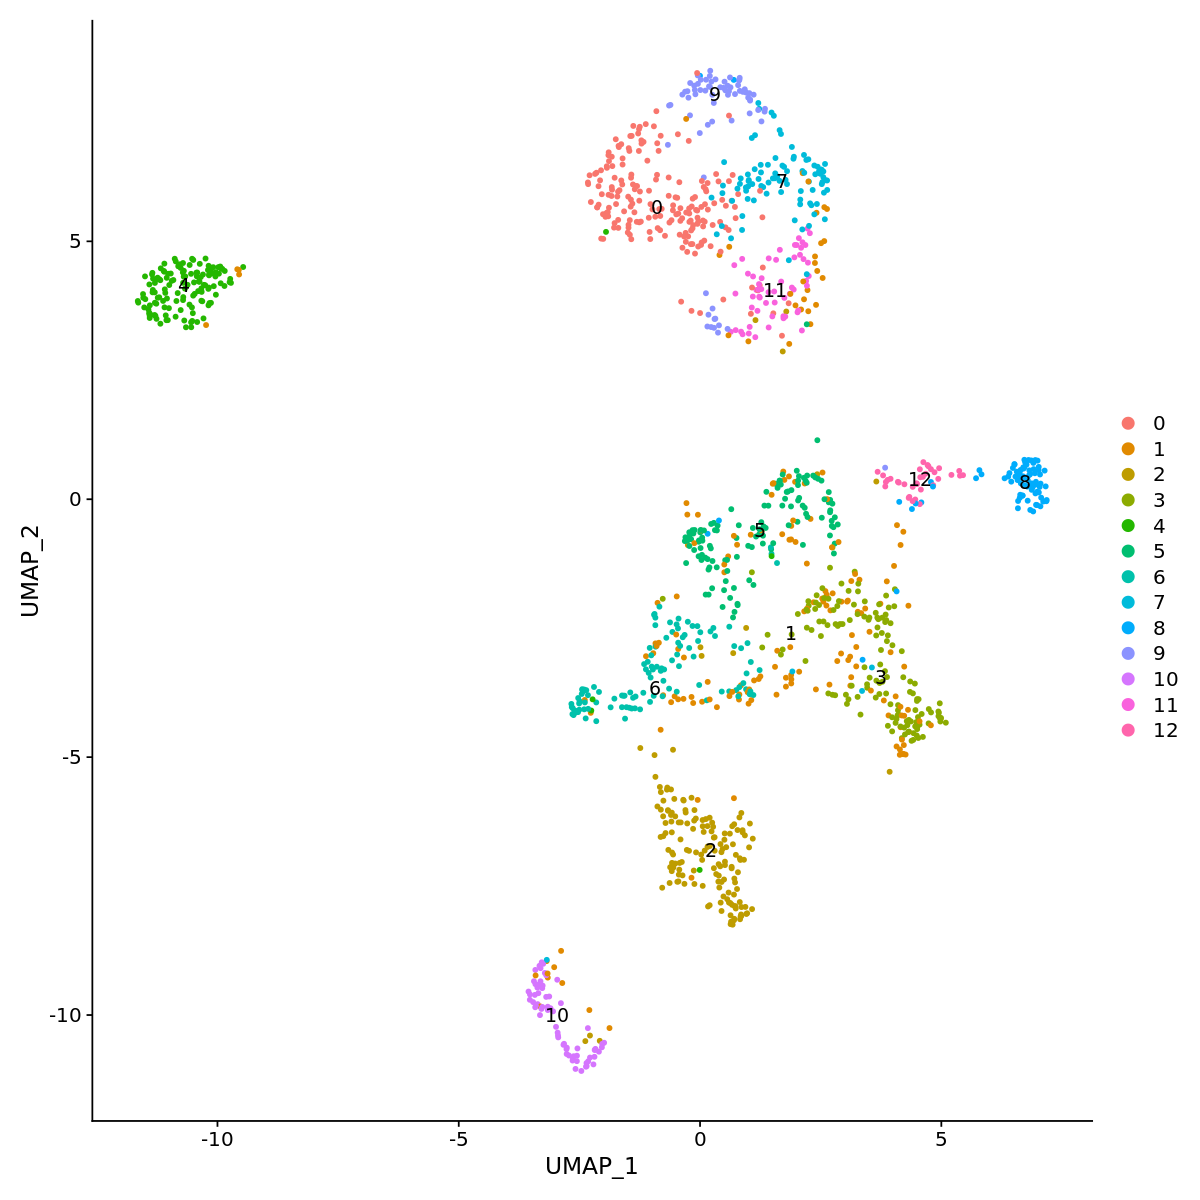

In [28]:
mut_seu <- RunPCA(mut_seu, verbose = FALSE)
mut_seu <- RunUMAP(mut_seu, dims = 1:30, verbose = FALSE)

mut_seu <- FindNeighbors(mut_seu, dims = 1:15, verbose = FALSE)
mut_seu <- FindClusters(mut_seu, verbose = FALSE)
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(mut_seu, label = TRUE) 

In [38]:
genes_per_cell <- Matrix::colSums(wt_seu@assays$RNA >0)

ERROR: Error in wt_seu@assays$RNA > 0: comparison (6) is possible only for atomic and list types


In [13]:
VlnPlot(object = wt_seu, features.plot = c("nGene"))

ERROR: Error in VlnPlot(object = wt_seu, features.plot = c("nGene")): unused argument (features.plot = c("nGene"))


In [31]:
median(wt_seu@meta.data$nFeature_RNA)

[1] 834

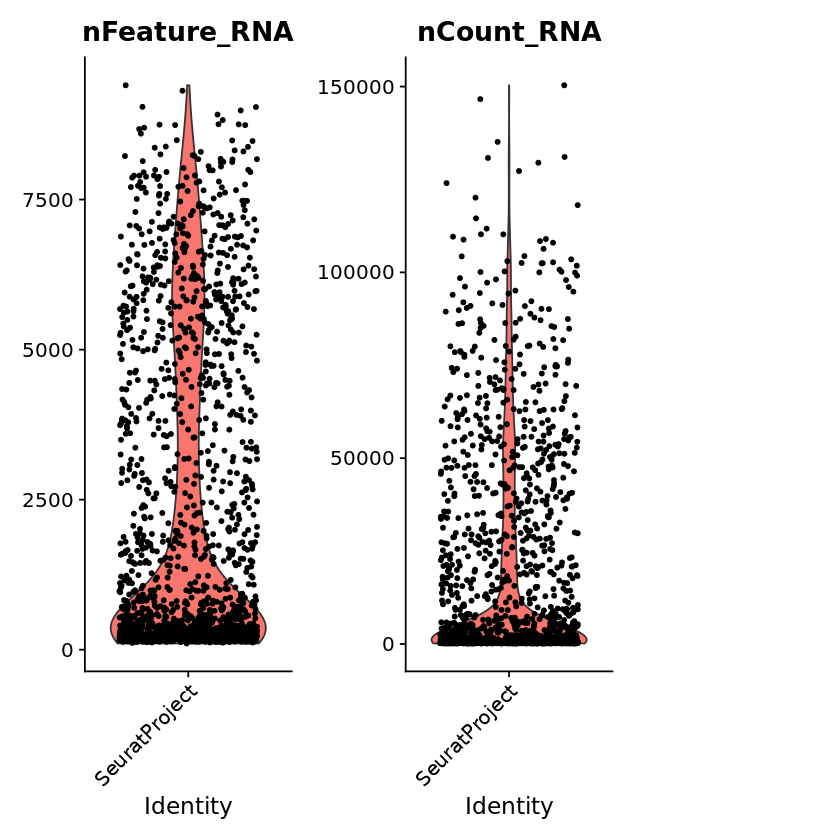

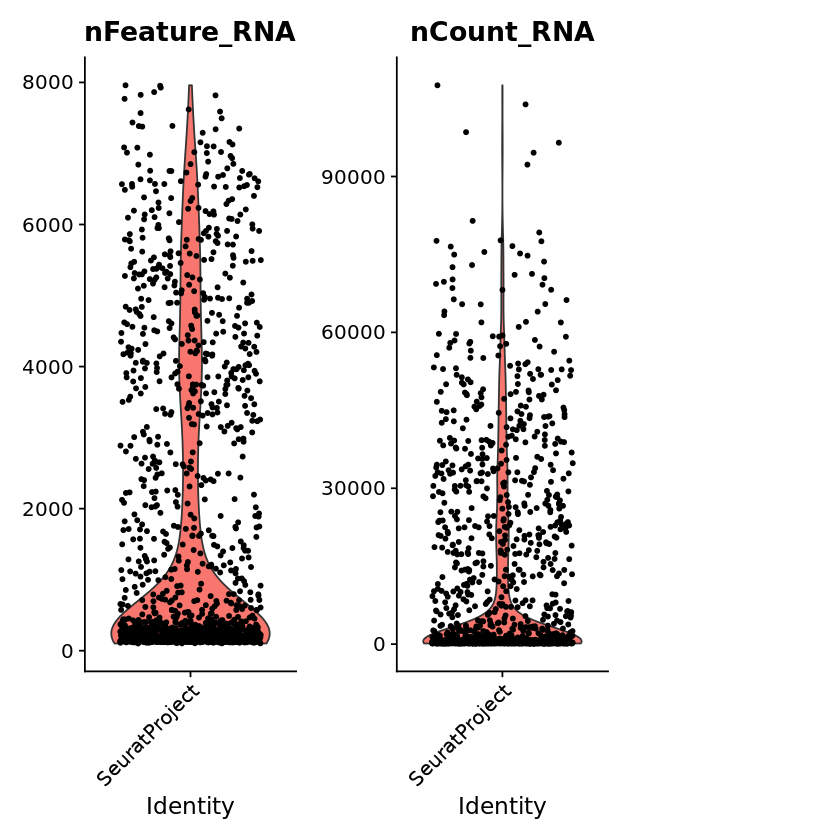

In [25]:
VlnPlot(wt_seu, features = c("nFeature_RNA", "nCount_RNA"), ncol = 3)
VlnPlot(mut_seu, features = c("nFeature_RNA", "nCount_RNA"), ncol = 3)